In [1]:
from multiprocessing import cpu_count

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, KMeans

# Imports
import os,sys
import re
import string
import math
import pickle

import re, numpy as np, pandas as pd
from pprint import pprint
from collections import OrderedDict

# Gensim
import gensim,  logging, warnings
import gensim.corpora as corpora

from gensim.models import LdaModel, TfidfModel
from gensim.similarities import MatrixSimilarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.keyedvectors import KeyedVectors
import gensim.downloader as gensimapi


# Plotting & graphs
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors


#import Utils
from utils import get_corpus_dataframe , pandas_highlight_max, pandas_highlight_min
from DocSim import DocSim

# Basic configuration 
%matplotlib inline
warnings.filterwarnings('ignore') 
#warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
# Load data 
# Import Dataset into a Pandas Dataframe
df = get_corpus_dataframe(eu_only=False)

# load preprocessed data 
with open("data_ready.sav", "rb") as fp:   # Unpickling
    data_ready = pickle.load(fp)


#number of documents
if (df.shape[0] != len(data_ready) or df.shape[0]<1):
    raise ValueError("Error while determining document corpus length")
else:
    N_DOCUMENTS = df.shape[0]

In [16]:
# plotting helpers

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata =  hcluster.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata



In [4]:
# 1. Topics Distribution Method

lda_topicdistributions_similaritiesmodel_filename ='./saved_state/df_lda_topicdistributions_similarities.pkl'
if os.path.isfile(lda_topicdistributions_similaritiesmodel_filename):
    df_topics_dist_similarities = pd.read_pickle(lda_topicdistributions_similaritiesmodel_filename)
else:
    #load LDA Model
    lda_model =  LdaModel.load('./saved_state/lda.model')
    
    # number of topics
    N_TOPICS=len(lda_model.get_topics())
    
    #get dictionary
    id2word=lda_model.id2word

    # get corpus
    corpus = [id2word.doc2bow(text) for text in data_ready]

    # # Get topic distributions for each document
    get_document_topics = [lda_model.get_document_topics(item,minimum_probability=0.0) for item in corpus]

    df_dt_dist_columns = ["Topic"+str(x).zfill(1) for x in range(N_TOPICS)]
    df_dt_dist = pd.DataFrame(np.array(get_document_topics)[..., 1],index=df.index, columns=df_dt_dist_columns)
    df_dt_dist[df_dt_dist < 0.01] = 0
    df_dt_dist = df_dt_dist.round(3)

    # df_dt_dist

    # calculate similarity matrix
    topics_dist_similarity_matrix = cosine_similarity(df_dt_dist, df_dt_dist)

    df_topics_dist_similarities = pd.DataFrame(np.array(topics_dist_similarity_matrix),index=df.index, columns=df.index)
    df_topics_dist_similarities[df_topics_dist_similarities < 0.01] = 0
    df_topics_dist_similarities = df_topics_dist_similarities.round(3)
    
    df_topics_dist_similarities.to_pickle(lda_topicdistributions_similaritiesmodel_filename)
    
df_topics_dist_similarities_highlighted=df_topics_dist_similarities.style.apply(pandas_highlight_max, color='darkorange', axis=1)

df_topics_dist_similarities_highlighted



country,china,denmark,finland,france,germany,india,italy,japan,luxembourg,mexico,sweden,uk
country,,,,,,,,,,,,
china,1,0.024,0.104,0.447,0.472,0.541,0.461,0.825,0.452,0.454,0.308,0.392
denmark,0.024,1,0.756,0.635,0.875,0.686,0.74,0.556,0.827,0.765,0.949,0.876
finland,0.104,0.756,1,0.651,0.808,0.669,0.72,0.594,0.783,0.737,0.829,0.78
france,0.447,0.635,0.651,1,0.821,0.985,0.985,0.691,0.937,0.977,0.75,0.913
germany,0.472,0.875,0.808,0.821,1,0.893,0.907,0.875,0.968,0.923,0.981,0.972
india,0.541,0.686,0.669,0.985,0.893,1,0.995,0.797,0.971,0.992,0.82,0.95
italy,0.461,0.74,0.72,0.985,0.907,0.995,1,0.766,0.983,0.999,0.851,0.968
japan,0.825,0.556,0.594,0.691,0.875,0.797,0.766,1,0.817,0.776,0.782,0.789
luxembourg,0.452,0.827,0.783,0.937,0.968,0.971,0.983,0.817,1,0.99,0.931,0.995


In [5]:
# 2. W2V Cenrtoid Method

w2v_centroid_similaritiesmodel_filename ='./saved_state/df_w2v_centroid_similarities.pkl'
if os.path.isfile(w2v_centroid_similaritiesmodel_filename):
    df_w2v_similarities_centroid = pd.read_pickle(w2v_centroid_similaritiesmodel_filename)
else:
    # load word2vec google news model
    if (google_model is None or type(google_model)!=gensim.models.keyedvectors.Word2VecKeyedVectors or google_model.vector_size!=300):
        google_model  = gensimapi.load("word2vec-google-news-300")  # load news word2vec vectors
        google_model.init_sims(replace=True)
    
    # Prepare DocSim
    ds = DocSim(google_model)
    all_scores_centroid = np.empty((N_DOCUMENTS, N_DOCUMENTS), float)
    for idx in range(0,12):
        source_doc = df['clean_content'][idx]
        target_docs = [df['clean_content'][i] for i in range(0,N_DOCUMENTS)]
        sim_scores = ds.calculate_similarity(source_doc, target_docs)
        for score in sim_scores:
            all_scores_centroid[idx,score['doc']] = score['score']

    df_w2v_similarities_centroid = pd.DataFrame(np.array(all_scores_centroid),index=df.index, columns=df.index)
    df_w2v_similarities_centroid[df_w2v_similarities_centroid < 0.01] = 0
    df_w2v_similarities_centroid = df_w2v_similarities_centroid.round(3)
    
    df_w2v_similarities_centroid.to_pickle(w2v_centroid_similaritiesmodel_filename)
    
df_w2v_similarities_centroid_highlighted=df_w2v_similarities_centroid.style.apply(pandas_highlight_max, color='darkorange', axis=1)

df_w2v_similarities_centroid_highlighted

country,china,denmark,finland,france,germany,india,italy,japan,luxembourg,mexico,sweden,uk
country,,,,,,,,,,,,
china,1,0.936,0.924,0.916,0.939,0.953,0.925,0.962,0.952,0.948,0.946,0.949
denmark,0.936,1,0.994,0.987,0.992,0.988,0.986,0.977,0.989,0.986,0.983,0.981
finland,0.924,0.994,1,0.991,0.991,0.985,0.989,0.974,0.985,0.982,0.98,0.976
france,0.916,0.987,0.991,1,0.993,0.986,0.995,0.97,0.987,0.984,0.979,0.974
germany,0.939,0.992,0.991,0.993,1,0.989,0.991,0.979,0.993,0.989,0.986,0.984
india,0.953,0.988,0.985,0.986,0.989,1,0.985,0.988,0.993,0.992,0.986,0.985
italy,0.925,0.986,0.989,0.995,0.991,0.985,1,0.971,0.987,0.985,0.979,0.972
japan,0.962,0.977,0.974,0.97,0.979,0.988,0.971,1,0.984,0.98,0.98,0.971
luxembourg,0.952,0.989,0.985,0.987,0.993,0.993,0.987,0.984,1,0.992,0.988,0.988


In [6]:
# 3. W2V WMD Method

w2v_wdm_similaritiesmodel_filename ='./saved_state/df_wmd_similarities.pkl'
if os.path.isfile(w2v_wdm_similaritiesmodel_filename):
    df_w2v_similarities_wmdistance = pd.read_pickle(w2v_wdm_similaritiesmodel_filename)
else:
    # load word2vec google news model
    if (google_model is None or type(google_model)!=gensim.models.keyedvectors.Word2VecKeyedVectors or google_model.vector_size!=300):
        google_model  = gensimapi.load("word2vec-google-news-300")  # load news word2vec vectors
        google_model.init_sims(replace=True)

    all_scores_wmd = np.empty((N_DOCUMENTS, N_DOCUMENTS), float)
    target_docs = [df['clean_content'][i] for i in range(0,N_DOCUMENTS)]
    for idx in range(0,N_DOCUMENTS):
        source_doc = df['clean_content'][idx]
        sim_scores = [google_model.wmdistance(source_doc, target_doc) for target_doc in target_docs]
        sim_scores = [1-score for score in sim_scores]
        #print(f'idx={idx} --> {sim_scores}')
        all_scores_wmd[idx,:] = sim_scores


    df_w2v_similarities_wmdistance = pd.DataFrame(np.array(all_scores_wmd),index=df.index, columns=df.index)
    df_w2v_similarities_wmdistance[df_w2v_similarities_wmdistance < 0.01] = 0
    df_w2v_similarities_wmdistance = df_w2v_similarities_wmdistance.round(3)
    
    df_w2v_similarities_wmdistance.to_pickle(w2v_wdm_similaritiesmodel_filename) 
                                             

df_w2v_similarities_wmdistances_highlighted=df_w2v_similarities_wmdistance.style.apply(pandas_highlight_max, color='darkorange', axis=1)

df_w2v_similarities_wmdistances_highlighted

country,china,denmark,finland,france,germany,india,italy,japan,luxembourg,mexico,sweden,uk
country,,,,,,,,,,,,
china,1,0.922636,0.923021,0.936817,0.939975,0.947144,0.909802,0.938993,0.944418,0.94086,0.93444,0.929864
denmark,0.922636,1,0.969497,0.953945,0.952973,0.939537,0.926563,0.916662,0.943927,0.934878,0.952161,0.941615
finland,0.923021,0.969497,1,0.950664,0.952595,0.935221,0.924384,0.914496,0.937389,0.930969,0.949023,0.929152
france,0.936817,0.953945,0.950664,1,0.972685,0.962457,0.942894,0.939091,0.957093,0.952159,0.956726,0.949257
germany,0.939975,0.952973,0.952595,0.972685,1,0.961504,0.934492,0.93963,0.955146,0.946497,0.965281,0.95742
india,0.947144,0.939537,0.935221,0.962457,0.961504,1,0.948284,0.960936,0.967948,0.965823,0.957546,0.964793
italy,0.909802,0.926563,0.924384,0.942894,0.934492,0.948284,1,0.927507,0.939189,0.953988,0.938776,0.944533
japan,0.938993,0.916662,0.914496,0.939091,0.93963,0.960936,0.927507,1,0.948117,0.947951,0.935779,0.942255
luxembourg,0.944418,0.943927,0.937389,0.957093,0.955146,0.967948,0.939189,0.948117,1,0.959011,0.948008,0.958361


In [7]:
# 3. W2V WMD Method
doc2vec_similaritiesmodel_filename ='./saved_state/d2v.model'
if os.path.isfile(doc2vec_similaritiesmodel_filename):
    doc2vec_model = Doc2Vec.load(doc2vec_similaritiesmodel_filename)
else:
    tagged_data = [TaggedDocument(words=[ w for w in _d], tags=[str(df.index[i])]) for i, _d in enumerate(data_ready)]

    max_epochs = 100
    vec_size = 120
    alpha = 0.025

    doc2vec_model = Doc2Vec(size=vec_size,
                    alpha=alpha, 
                    min_alpha=0.00025,
                    min_count=1,
                    dm =0)

    doc2vec_model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        #print('iteration {0}'.format(epoch))
        doc2vec_model.train(tagged_data,
                    total_examples=doc2vec_model.corpus_count,
                    epochs=doc2vec_model.iter)
        # decrease the learning rate
        doc2vec_model.alpha -= 0.0002
        # fix the learning rate, no decay
        doc2vec_model.min_alpha = doc2vec_model.alpha

    doc2vec_model.save(doc2vec_similaritiesmodel_filename)
    doc2vec_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)



In [8]:

all_scores_d2v = np.empty((N_DOCUMENTS, N_DOCUMENTS), float)
target_docs = [df.index[i] for i in range(0,N_DOCUMENTS)]
for idx in range(0,N_DOCUMENTS):
    source_doc = df.index[idx]
    sim_scores = [doc2vec_model.docvecs.similarity(source_doc, target_doc) for target_doc in target_docs]
    #sim_scores = [1-score for score in sim_scores]
    #print(f'idx={idx} --> {sim_scores}')
    all_scores_d2v[idx,:] = sim_scores
        

# similarity_matrix = np.dot(model.wv.syn0, model.wv.syn0.T)
df_doc2vec_similarities = pd.DataFrame(np.array(all_scores_d2v),index=df.index, columns=df.index)
df_doc2vec_similarities[df_doc2vec_similarities < 0.01] = 0
df_doc2vec_similarities = df_doc2vec_similarities.round(3)

df_doc2vec_similarities_highlighted=df_doc2vec_similarities.style.apply(pandas_highlight_max, color='darkorange', axis=1)
df_doc2vec_similarities_highlighted

country,china,denmark,finland,france,germany,india,italy,japan,luxembourg,mexico,sweden,uk
country,,,,,,,,,,,,
china,1,0.096,0.242,0.181,0.212,0.152,0.27,0.312,0.224,0.2,0.238,0.214
denmark,0.096,1,0.222,0.167,0.215,0.178,0.114,0.233,0.217,0.195,0.259,0.26
finland,0.242,0.222,1,0.213,0.304,0.191,0.279,0.274,0.262,0.28,0.266,0.254
france,0.181,0.167,0.213,1,0.172,0.18,0.238,0.235,0.169,0.217,0.184,0.182
germany,0.212,0.215,0.304,0.172,1,0.159,0.206,0.212,0.318,0.275,0.29,0.226
india,0.152,0.178,0.191,0.18,0.159,1,0.166,0.209,0.2,0.243,0.195,0.274
italy,0.27,0.114,0.279,0.238,0.206,0.166,1,0.254,0.227,0.251,0.219,0.168
japan,0.312,0.233,0.274,0.235,0.212,0.209,0.254,1,0.219,0.238,0.238,0.194
luxembourg,0.224,0.217,0.262,0.169,0.318,0.2,0.227,0.219,1,0.215,0.264,0.294


## Mean Similarities

In [9]:
df_mean_similarities = pd.concat([df_topics_dist_similarities, df_w2v_similarities_centroid, df_w2v_similarities_wmdistance,df_doc2vec_similarities]).groupby(level=0).mean()
df_mean_similarities[df_mean_similarities < 0.01] = 0
df_mean_similarities = df_mean_similarities.round(3)
df_mean_similarities_highlighted=df_mean_similarities.style.apply(pandas_highlight_max, color='darkorange', axis=1)
df_mean_similarities_highlighted

country,china,denmark,finland,france,germany,india,italy,japan,luxembourg,mexico,sweden,uk
country,,,,,,,,,,,,
china,1,0.495,0.548,0.62,0.641,0.648,0.641,0.759,0.643,0.636,0.607,0.621
denmark,0.495,1,0.735,0.686,0.759,0.698,0.692,0.671,0.744,0.72,0.786,0.765
finland,0.548,0.735,1,0.701,0.764,0.695,0.728,0.689,0.742,0.732,0.756,0.735
france,0.62,0.686,0.701,1,0.74,0.778,0.79,0.709,0.763,0.783,0.717,0.755
germany,0.641,0.759,0.764,0.74,1,0.751,0.76,0.751,0.809,0.783,0.806,0.785
india,0.648,0.698,0.695,0.778,0.751,1,0.774,0.739,0.783,0.798,0.74,0.793
italy,0.641,0.692,0.728,0.79,0.76,0.774,1,0.73,0.784,0.797,0.747,0.763
japan,0.759,0.671,0.689,0.709,0.751,0.739,0.73,1,0.742,0.735,0.734,0.724
luxembourg,0.643,0.744,0.742,0.763,0.809,0.783,0.784,0.742,1,0.789,0.783,0.809


## Clustering

In [10]:
mean_similarities_cluster_matrix = df_mean_similarities.as_matrix()
 

# # kmeans2_wmd = KMeans(n_clusters=2, random_state=100).fit(all_scores_wmd)
# # kmeans3_wmd = KMeans(n_clusters=3, random_state=100).fit(all_scores_wmd)

# # kmeans2_centroid = KMeans(n_clusters=2, random_state=100).fit(all_scores_centroid)
# # kmeans3_centroid = KMeans(n_clusters=3, random_state=100).fit(all_scores_centroid)

# kmeans2_mean = KMeans(n_clusters=2, random_state=100).fit(mean_similarities_cluster_matrix)
# kmeans3_mean = KMeans(n_clusters=3, random_state=100).fit(mean_similarities_cluster_matrix)


# #you can see the labels with:
# # print(kmeans2_wmd.labels_)
# # print (kmeans3_wmd.labels_)

# # print (kmeans2_centroid.labels_)
# # print (kmeans3_centroid.labels_)

# print (kmeans2_mean.labels_)
# print (kmeans3_mean.labels_)

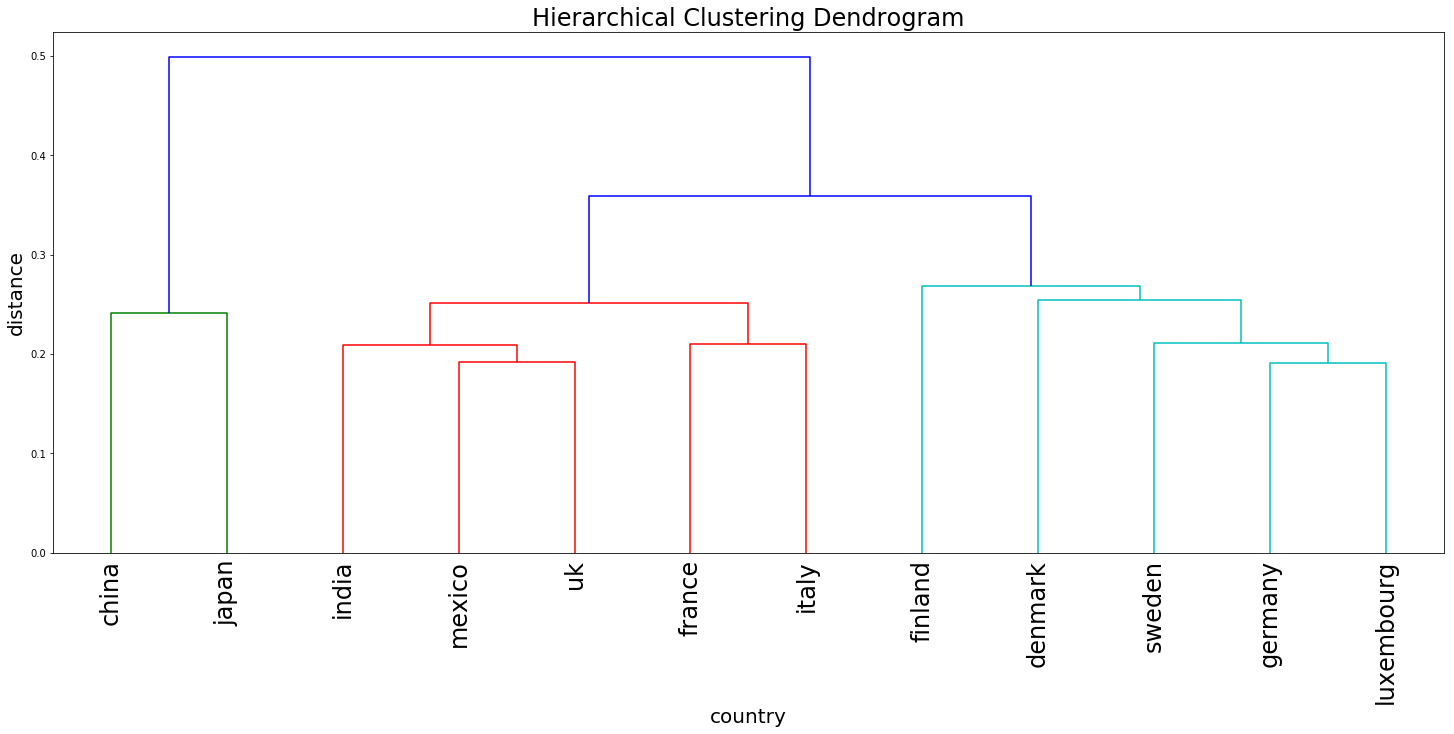

In [26]:
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as hcluster

plt.figure(figsize=(20,10) )
plt.title('Hierarchical Clustering Dendrogram', fontsize=24)
plt.xlabel('country', fontsize=20)
plt.ylabel('distance', fontsize=20)

distVec = ssd.squareform(1-mean_similarities_cluster_matrix)
linkage = hcluster.linkage(distVec,'ward')
dendro  = hcluster.dendrogram(linkage,
                              leaf_label_func=lambda x: df.index[x],
                              leaf_rotation=90.,
                              leaf_font_size=24,
                              show_contracted=True,
                             )

# fancy_dendrogram(
#     linkage,
#     leaf_label_func=lambda x: df.index[x],
#     leaf_rotation=90.,
#     leaf_font_size=18.,
#     show_contracted=True,
#     annotate_above=10,
#     max_d=0.4,
# )

plt.margins(x=0, y=0)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
def remove_common_words(dictionary,corpus,low_value=0.01):
    
    tfidf = TfidfModel(corpus, id2word=id2word)

    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = [] #reinitialize to be safe. You can skip this.
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  

        #reassign        
        corpus[i] = new_bow
    return corpus

## PRINT STATISTICS

### Print Top Words per Topic

In [ ]:
from operator import itemgetter
from collections import OrderedDict
from collections import defaultdict

# the higher the TF*IDF score (weight), the rarer the term and vice versa
tfidf = TfidfModel(corpus, id2word=id2word)
d = {}
low_value = 0.005
low_value_words = []
for bow in corpus:
    d={id2word[key]: value for (key, value) in tfidf[bow] if value < low_value}
    sorted_x = OrderedDict(sorted(d.items(), key=lambda t: t[1]))
    print(sorted_x)
    low_value_words += [id for id, value in tfidf[bow] if value > low_value]


# print low value words
# for x in [id2word[word_id ] for word_id  in low_value_words]:
#     print(x)

print(sorted_x)

In [ ]:
def evaluate_graph(texts, limit_start,limit_end,up_limit,topn_words,low_values):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
   
    c_v = []
    lm_list = []
    
    for above_limit in up_limit: #[.75,.80,.85,.90,.95,1]:
        
        for keepn in topn_words: #[2500,3000,3200,3400,8000]:
            for low_cut_limit in low_values:
            # Create Dictionary
                id2word = corpora.Dictionary(texts)
                # Filter out words that occur less than 2 documents, or more than 85% of the documents.
                id2word.filter_extremes(no_below=2, no_above=above_limit,keep_n=keepn)

                # Create Corpus: Term Document Frequency
                corpus = [id2word.doc2bow(text) for text in texts]

                #filter out most common words
                corpus= remove_common_words(id2word,corpus,low_value = low_cut_limit) 

                for num_topics in range(limit_start, limit_end):
                    lm = gensim.models.ldamodel.LdaModel(corpus=corpus,
                           id2word=id2word,
                           num_topics=num_topics, 
                           random_state=100,
                           update_every=1,
                           passes=20,
                           alpha='auto',
                           minimum_probability=0.05,
                           per_word_topics=True)
                    lm_list.append(lm)
                    cm = CoherenceModel(model=lm, texts=texts, dictionary=id2word, coherence='c_v',processes=4)
                    coherence_value = cm.get_coherence()
                    s = f'num_topics={num_topics} , above_limit={above_limit} ,keep_n={keepn}, low_cut={low_cut_limit} , coherence = {coherence_value}'
                    c_v.append(coherence_value)
                    print(s)
  
    # Show graph
#     x = range(2, limit)
#     plt.plot(x, c_v)
#     plt.xlabel("num_topics")
#     plt.ylabel("Coherence score")
#     plt.legend(("c_v"), loc='best')
#     plt.show()
    
    return lm_list, c_v

model_list, coherence_values = evaluate_graph(texts=data_ready, limit_start=3,limit_end=8,up_limit=[0.95,1],topn_words=[4600],low_values=[0.01,0.05,0.1,0.15])

# Show graph
# x = range(2, 10)
# plt.plot(x, coherence_values)
# plt.xlabel("num_topics")
# plt.ylabel("Coherence score")
# plt.legend(("c_v"), loc='best')
# plt.show()

##  What is the Dominant topic and its percentage contribution in each document

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords] ,name=df.iloc[i].name))
            else:
                break
   

    # Add original text to the end of the output
    contents = pd.Series(texts,index=df.index)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Keywords','Text']
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

df_topic_sents_keywords

## Documents - Topics Distribution

In [ ]:
def color_positive_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for positive
    strings, black otherwise.
    """
    color='black'
    
    if val>0.5:
        color = 'red' 
    elif val > 0:
        color = 'green'
    else:
        color='black'
        
    return 'color: %s' % color

get_document_topics = [lda_model.get_document_topics(item,minimum_probability=0.0) for item in corpus]

df_dt_dist_columns = ["Topic"+str(x).zfill(1) for x in range(N_TOPICS)]
df_dt_dist = pd.DataFrame(np.array(get_document_topics)[..., 1],index=df.index, columns=df_dt_dist_columns)
df_dt_dist[df_dt_dist < 0.01] = 0
df_dt_dist = df_dt_dist.round(3)
df_dt_dist = df_dt_dist.style.applymap(color_positive_red)



df_dt_dist

In [ ]:


def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data[data<1].max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data[data<1].max().max() 
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

array = np.array(get_document_topics)[..., 1]

sim = np.empty((array.shape[0], array.shape[0]), float)
for j in range(array.shape[0]):
    sim[j]=cosine_similarity([array[j]],array)
 
df_doc_similarities = pd.DataFrame(np.array(sim),index=df.index, columns=df.index)
df_doc_similarities[df_doc_similarities < 0.01] = 0
df_doc_similarities = df_doc_similarities.round(3)
df_doc_similarities_highlighted=df_doc_similarities.style.apply(highlight_max, color='darkorange', axis=1)

df_doc_similarities_highlighted


In [ ]:
similarities_cluster_matrix = df_doc_similarities.as_matrix()

dbscan = DBSCAN().fit_predict(array) # ,metric='cityblock'
kmeans2 = KMeans(n_clusters=2, random_state=100).fit(array)
kmeans3 = KMeans(n_clusters=3, random_state=100).fit(array)
kmeans4 = KMeans(n_clusters=4, random_state=100).fit(array)


#you can see the labels with:
print(kmeans2.labels_)
print (kmeans3.labels_)
print (kmeans4.labels_)


 ## The most representative sentence for each topic

## Wordcloud Per Topic

In [ ]:
 # 1. Wordcloud of Top N words in each topic


topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, N_TOPICS, figsize=(18,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.max_words=15
    cloud.color_func = lambda *args, **kwargs: word_plotting_colors[i]
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()



## Wordcloud (N-GRAM) Per Topic

In [ ]:
topic_ngrams_filter = lambda dict_topic:  {k: v for k, v in dict_topic.items() if '_' in k}
topics = lda_model.show_topics(num_words=1000,formatted=False)


fig, axes = plt.subplots(1, N_TOPICS, figsize=(18,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = topic_ngrams_filter(dict(topics[i][1]))
    cloud.max_words=10
    cloud.color_func = lambda *args, **kwargs: word_plotting_colors[i]
    cloud.generate_from_frequencies(topic_words, max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

print(topic_ngrams_filter(dict(topics[i][1])))

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(N_TOPICS), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

In [ ]:
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
from collections import Counter
topics = lda_model.show_topics(formatted=False,num_words=5)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, N_TOPICS, figsize=(20,14), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## pyLDAVis

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word,sort_topics=False)
vis